# Bank Card reader

In this code I implemented a bank card scanner using OCR-A template matching.

![alt text](https://drive.google.com/uc?id=1uTtChEW7wd3RuKMA-obAv1qQyTaytTKU)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
cd /content/drive/MyDrive/CIS5810/extra_project

/content/drive/MyDrive/CIS5810/extra_project


In [30]:
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from imageutils import display

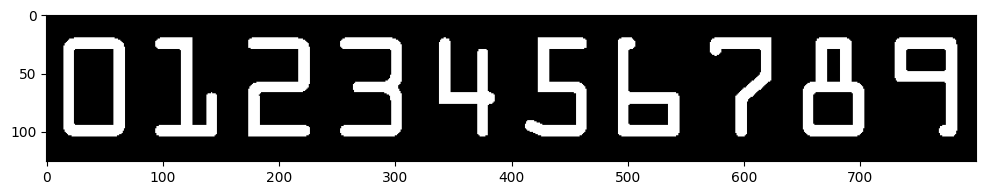

In [31]:
# map the first digit of a debit card number to the debit card type
CARD_TYPE = {
	"3": "American Express",
	"4": "Visa",
	"5": "MasterCard",
	"6": "Discover Card"
}

# load the reference OCR-A image from disk, convert it to grayscale,
# threshold and invert it such that the digits appear as white on a black background
ref = cv2.imread("IM/number_reference.png")
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]
display(ref)

# find contours of the digits in the OCR-A image
# sort them from left to right
# initialize a dictionary to map digit name to the ROI
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
refCnts = imutils.grab_contours(refCnts)
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
digits = {}

In [32]:
# loop over the OCR-A reference contours and populate an array with all digits
for (i, c) in enumerate(refCnts):
	# compute the bounding box for the digit, extract it, and resize it to a fixed size
	(x, y, w, h) = cv2.boundingRect(c)
	roi = ref[y:y + h, x:x + w]
	roi = cv2.resize(roi, (57, 88))

	# update the digits dictionary, mapping the digit name to the ROI
	digits[i] = roi

In [33]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread("IM/debit02.png")
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# initialize a rectangular and a square
# construct a kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))

# apply a whitehat morphological operator to find light regions against a dark background
# isolate the white card numbers from the black background
whitehat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)

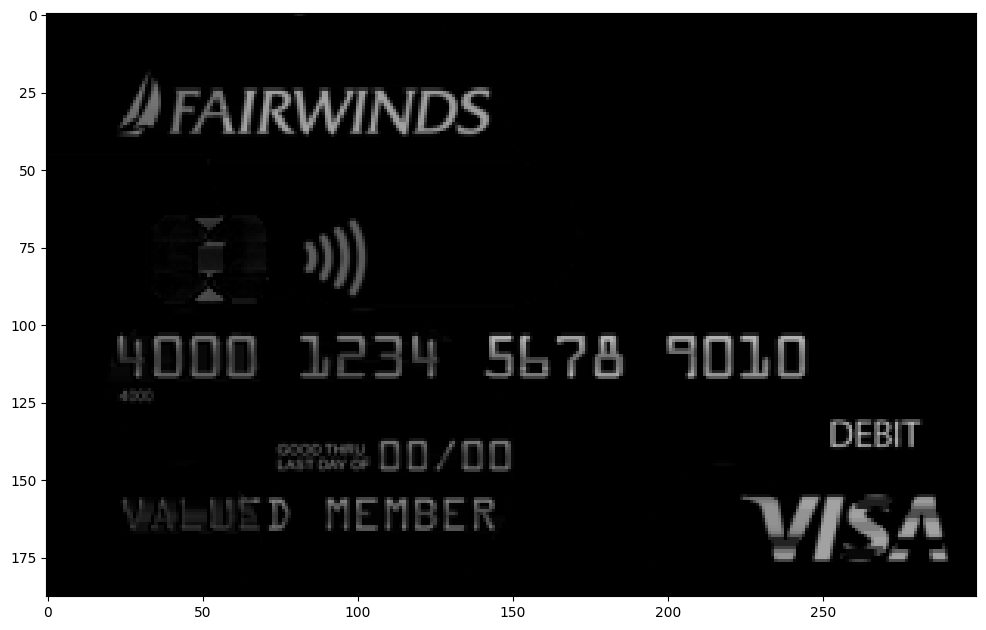

In [34]:
# the whitehat operation reveals light regions against a dark background
# display the resulting image below:
display(whitehat)

In this step, we isolate the digits by computing the absolute value of each element in the gradX array, and taking some steps to scale the values into the range [0-255] as the image is currently a floating point data type. To do this we compute the minVal and maxVal of gradX followed by our scaling equation shown (i.e., min/max normalization). The last step is to convert gradX to a uint8 which has a range of [0-255].

In [35]:
# compute the Scharr gradient of the whitehat image in the x-direction
# scale the rest back into the range [0, 255]
gradX = cv2.Sobel(whitehat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")


The result is shown in the image below:

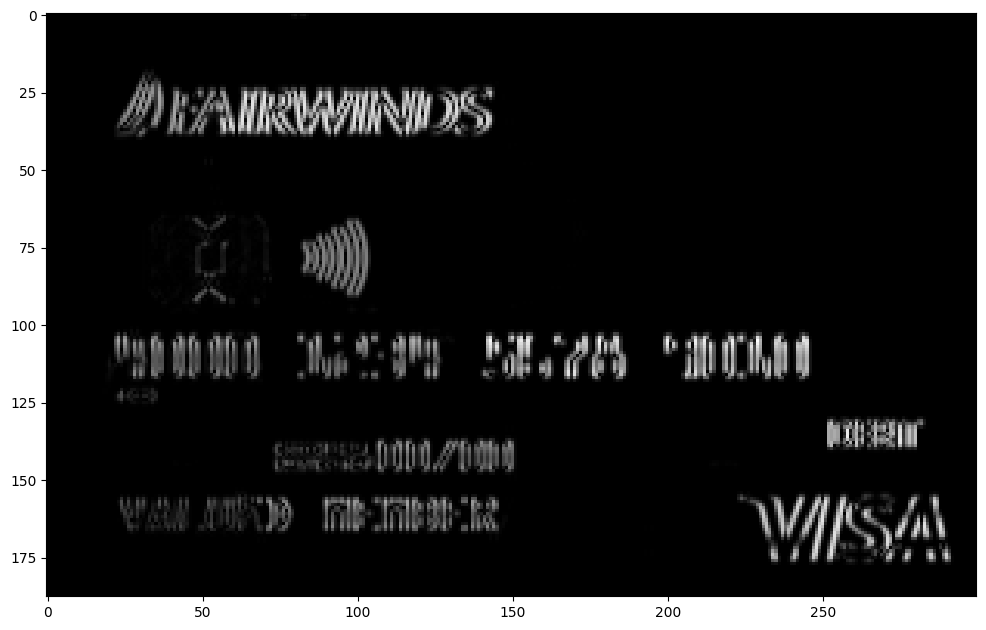

In [36]:
display(gradX)

In this step we close the gaps by a closing operation using our rectKernel again. Subsequently we perform an Otsu and binary threshold of the gradX image, followed by another closing operation.

In [37]:
# apply a closing operation using the rectangular kernel to help close gaps between digits
# apply Otsu's thresholding method to binarize the image
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# apply a second closing operation to the binary image again to help close gaps between digit regions
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)

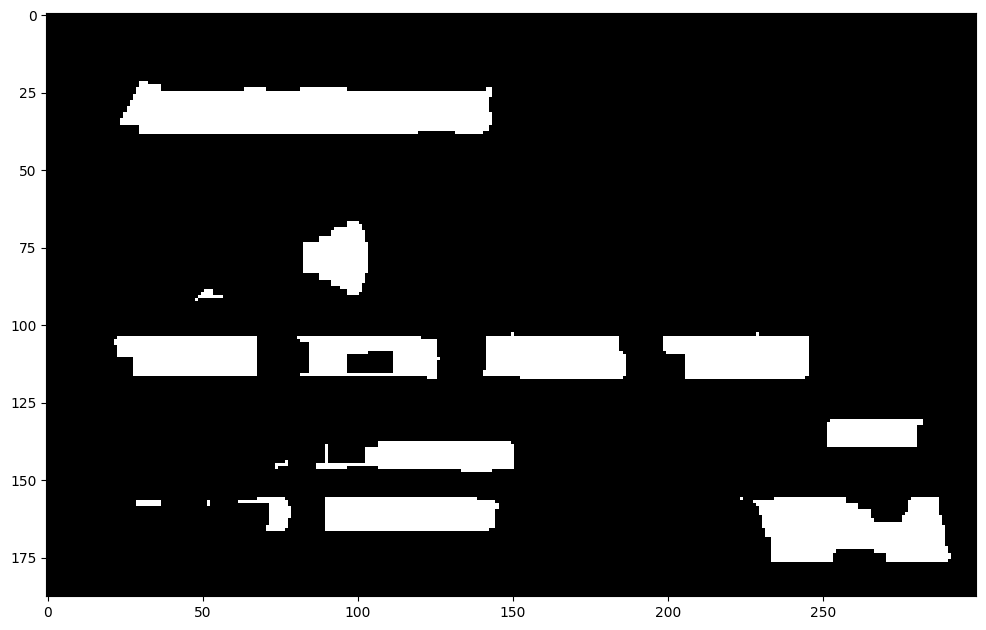

In [38]:
display(thresh)

In [39]:
# find contours in the thresholded image, then populate a list with digit locations
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
locs = []

# loop over the contours
for (i, c) in enumerate(cnts):
	# compute the bounding box of the contour
	# use the bounding box coordinates to derive the aspect ratio
	(x, y, w, h) = cv2.boundingRect(c)
	ar = w / float(h)

	# prune potential contours based on the aspect ratio of fixed size fonts with 4 groups of 4 digits
	if ar > 2.5 and ar < 4.0:
		# contours can further be pruned on minimum/maximum width and height
		if (w > 40 and w < 55) and (h > 10 and h < 20):
			# append the bounding box region of the digits group to our locations list
			locs.append((x, y, w, h))

# sort the digit locations from left-to-right
# initialize the list of classified digits
locs = sorted(locs, key=lambda x:x[0])
print(locs)

[(22, 104, 46, 13), (81, 104, 46, 14), (141, 103, 46, 15), (199, 103, 47, 15)]


In [40]:
output = []

# loop over the 4 groupings of 4 digits
for (i, (gX, gY, gW, gH)) in enumerate(locs):
	# initialize the list of group digits
	groupOutput = []

	# extract the group ROI of 4 digits from the grayscale image
	# apply thresholding to segment the digits from the background of the card
	group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
	group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

	# detect the contours of each individual digit in the group
	# sort the digit contours from left to right
	digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
	digitCnts = imutils.grab_contours(digitCnts)
	digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]

	# loop over the digit contours
	for c in digitCnts:
		# compute the bounding box of the individual digit
		# extract the digit and resize it to have the same fixed size as OCR-A ref
		(x, y, w, h) = cv2.boundingRect(c)
		roi = group[y:y + h, x:x + w]
		roi = cv2.resize(roi, (57, 88))

		# initialize a list of template matching scores
		scores = []

		# loop over the reference digit name and digit ROI
		for (digit, digitROI) in digits.items():
			# apply correlation-based template matching
			# take the score and update the scores list
			result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF)
			(_, score, _, _) = cv2.minMaxLoc(result)
			scores.append(score)

		# the classification for the digit ROI will be the reference digit name with the biggest template matching score
		groupOutput.append(str(np.argmax(scores)))

	# draw the digit classifications around the group
	cv2.rectangle(image, (gX - 5, gY - 5),(gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
	cv2.putText(image, "".join(groupOutput), (gX, gY - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

	# update the output digits list
	output.extend(groupOutput)

Credit Card Type: Visa
Credit Card #: 4000123456789010


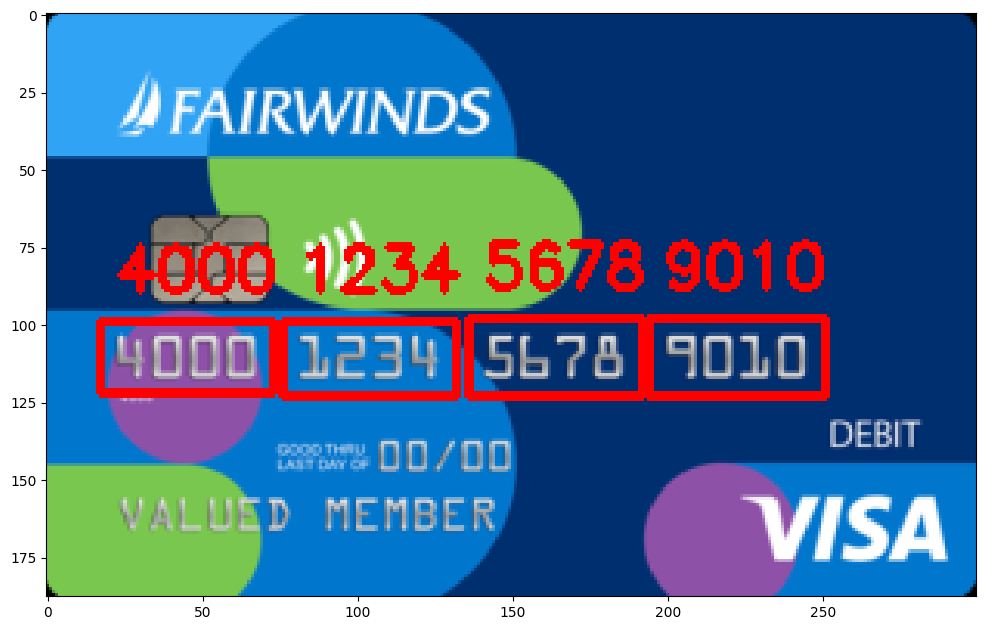

In [41]:
# display the output card information to the screen
print("Credit Card Type: {}".format(CARD_TYPE[output[0]]))
print("Credit Card #: {}".format("".join(output)))
display(image)